In [ ]:
from google.colab import files
files.upload()


The dataset was accessed directly from Kaggle by linking Google Colab with Kaggle account using the kaggle.json API key

In [2]:
import os
import shutil

# Make a directory for the Kaggle API key
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set the permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [3]:
!pip install -q kaggle


Dowloading Fruits and Vegetable diesease healthy vs rotten dataset

>The Fruit and Vegetable  Dataset consists of 28 directories, each representing a combination of healthy and rotten images for 14 different types of fruits and vegetables.


In [4]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten

Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.75G/4.77G [01:08<00:00, 49.3MB/s]
100% 4.77G/4.77G [01:08<00:00, 74.9MB/s]


In [5]:
!unzip -q fruit-and-vegetable-disease-healthy-vs-rotten.zip

In [6]:
!ls '/content/Fruit And Vegetable Diseases Dataset'

Apple__Healthy	     Grape__Healthy   Pomegranate__Healthy
Apple__Rotten	     Grape__Rotten    Pomegranate__Rotten
Banana__Healthy      Guava__Healthy   Potato__Healthy
Banana__Rotten	     Guava__Rotten    Potato__Rotten
Bellpepper__Healthy  Jujube__Healthy  Strawberry__Healthy
Bellpepper__Rotten   Jujube__Rotten   Strawberry__Rotten
Carrot__Healthy      Mango__Healthy   Tomato__Healthy
Carrot__Rotten	     Mango__Rotten    Tomato__Rotten
Cucumber__Healthy    Orange__Healthy
Cucumber__Rotten     Orange__Rotten


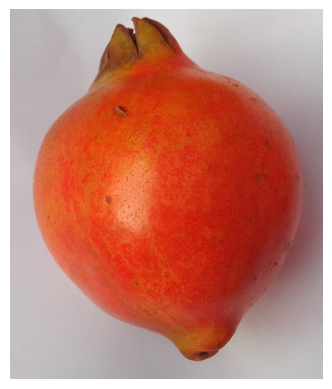

Image format: JPEG
Image size: (1525, 1801)


In [7]:
#Checking image in folder

from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/Fruit And Vegetable Diseases Dataset/Pomegranate__Healthy/FreshPomegranate (10).jpg'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
print(f"Image format: {img.format}")
print(f"Image size: {img.size}")

## Data preprocessing

Creating data generators for the training, validation, and testing sets using `ImageDataGenerator` and `flow_from_directory` and doing argumentation for training set.


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base path
base_dir = '/content/Fruit And Vegetable Diseases Dataset'

# Image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data preprocessing for validation and test sets (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=True

)

print(f"Training generator: {train_generator.samples} images in {train_generator.num_classes} classes")
print(f"Validation generator: {validation_generator.samples} images in {validation_generator.num_classes} classes")

Found 23431 images belonging to 28 classes.
Found 5846 images belonging to 28 classes.
Training generator: 23431 images in 28 classes
Validation generator: 5846 images in 28 classes


In [10]:
class_indices = train_generator.class_indices
class_indices

{'Apple__Healthy': 0,
 'Apple__Rotten': 1,
 'Banana__Healthy': 2,
 'Banana__Rotten': 3,
 'Bellpepper__Healthy': 4,
 'Bellpepper__Rotten': 5,
 'Carrot__Healthy': 6,
 'Carrot__Rotten': 7,
 'Cucumber__Healthy': 8,
 'Cucumber__Rotten': 9,
 'Grape__Healthy': 10,
 'Grape__Rotten': 11,
 'Guava__Healthy': 12,
 'Guava__Rotten': 13,
 'Jujube__Healthy': 14,
 'Jujube__Rotten': 15,
 'Mango__Healthy': 16,
 'Mango__Rotten': 17,
 'Orange__Healthy': 18,
 'Orange__Rotten': 19,
 'Pomegranate__Healthy': 20,
 'Pomegranate__Rotten': 21,
 'Potato__Healthy': 22,
 'Potato__Rotten': 23,
 'Strawberry__Healthy': 24,
 'Strawberry__Rotten': 25,
 'Tomato__Healthy': 26,
 'Tomato__Rotten': 27}

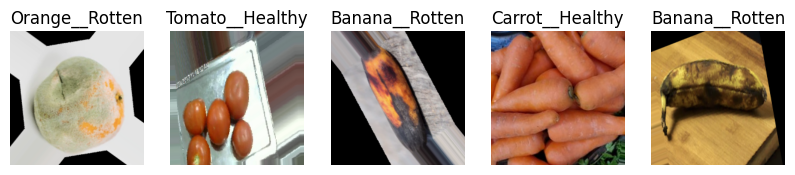

In [13]:
import matplotlib.pyplot as plt

num = 5

# batch of images and labels from the training generator
images, labels = next(train_generator)

# Class names from the generator
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.imshow(images[i])
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()

## **Model Building**
Building a model using VGG16.

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add a Flatten layer
model.add(Flatten())

# Add custom classification layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,144,668 (80.66 MB)

 Trainable params: 6,429,980 (24.53 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## **Model Training**

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

epochs = 25

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
331/733 ━━━━━━━━━━━━━━━━━━━━ 4:13 630ms/step - accuracy: 0.2669 - loss: 2.9640

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


443/733 ━━━━━━━━━━━━━━━━━━━━ 3:02 629ms/step - accuracy: 0.2864 - loss: 2.7863

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


647/733 ━━━━━━━━━━━━━━━━━━━━ 53s 620ms/step - accuracy: 0.3127 - loss: 2.5790

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.3218 - loss: 2.5158

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 535s 710ms/step - accuracy: 0.3219 - loss: 2.5151 - val_accuracy: 0.6326 - val_loss: 1.1748
Epoch 2/25
449/733 ━━━━━━━━━━━━━━━━━━━━ 2:49 596ms/step - accuracy: 0.4937 - loss: 1.5675

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


503/733 ━━━━━━━━━━━━━━━━━━━━ 2:16 595ms/step - accuracy: 0.4939 - loss: 1.5651

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


696/733 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - accuracy: 0.4945 - loss: 1.5596

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.4947 - loss: 1.5587

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 487s 664ms/step - accuracy: 0.4947 - loss: 1.5587 - val_accuracy: 0.6993 - val_loss: 1.0254
Epoch 3/25
158/733 ━━━━━━━━━━━━━━━━━━━━ 5:33 580ms/step - accuracy: 0.5394 - loss: 1.4253

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


294/733 ━━━━━━━━━━━━━━━━━━━━ 4:15 582ms/step - accuracy: 0.5326 - loss: 1.4357

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


681/733 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.5301 - loss: 1.4374

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.5304 - loss: 1.4365

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 479s 653ms/step - accuracy: 0.5304 - loss: 1.4365 - val_accuracy: 0.7200 - val_loss: 0.8938
Epoch 4/25
348/733 ━━━━━━━━━━━━━━━━━━━━ 3:41 575ms/step - accuracy: 0.5390 - loss: 1.4055

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


459/733 ━━━━━━━━━━━━━━━━━━━━ 2:37 575ms/step - accuracy: 0.5403 - loss: 1.3991

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


536/733 ━━━━━━━━━━━━━━━━━━━━ 1:53 576ms/step - accuracy: 0.5414 - loss: 1.3942

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5436 - loss: 1.3841

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 476s 649ms/step - accuracy: 0.5436 - loss: 1.3841 - val_accuracy: 0.7627 - val_loss: 0.7868
Epoch 5/25
125/733 ━━━━━━━━━━━━━━━━━━━━ 5:51 577ms/step - accuracy: 0.5641 - loss: 1.2745

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


291/733 ━━━━━━━━━━━━━━━━━━━━ 4:15 578ms/step - accuracy: 0.5624 - loss: 1.2862

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


301/733 ━━━━━━━━━━━━━━━━━━━━ 4:09 577ms/step - accuracy: 0.5624 - loss: 1.2863

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5624 - loss: 1.2947

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 507s 692ms/step - accuracy: 0.5624 - loss: 1.2948 - val_accuracy: 0.7670 - val_loss: 0.7969
Epoch 6/25
 19/733 ━━━━━━━━━━━━━━━━━━━━ 7:03 594ms/step - accuracy: 0.5810 - loss: 1.2460

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 98/733 ━━━━━━━━━━━━━━━━━━━━ 6:06 577ms/step - accuracy: 0.5707 - loss: 1.2674

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


287/733 ━━━━━━━━━━━━━━━━━━━━ 4:17 577ms/step - accuracy: 0.5707 - loss: 1.2827

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5725 - loss: 1.2787

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 474s 646ms/step - accuracy: 0.5725 - loss: 1.2787 - val_accuracy: 0.7612 - val_loss: 0.7968
Epoch 7/25
 42/733 ━━━━━━━━━━━━━━━━━━━━ 6:39 577ms/step - accuracy: 0.5462 - loss: 1.3483

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


491/733 ━━━━━━━━━━━━━━━━━━━━ 2:20 580ms/step - accuracy: 0.5759 - loss: 1.2489

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


659/733 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.5778 - loss: 1.2460

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5783 - loss: 1.2454

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 502s 646ms/step - accuracy: 0.5783 - loss: 1.2454 - val_accuracy: 0.7846 - val_loss: 0.7180
Epoch 8/25
257/733 ━━━━━━━━━━━━━━━━━━━━ 4:31 570ms/step - accuracy: 0.6023 - loss: 1.1674

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


635/733 ━━━━━━━━━━━━━━━━━━━━ 56s 578ms/step - accuracy: 0.5964 - loss: 1.1866

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


662/733 ━━━━━━━━━━━━━━━━━━━━ 41s 578ms/step - accuracy: 0.5962 - loss: 1.1873

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5957 - loss: 1.1891

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 477s 651ms/step - accuracy: 0.5957 - loss: 1.1891 - val_accuracy: 0.7855 - val_loss: 0.6711
Epoch 9/25
314/733 ━━━━━━━━━━━━━━━━━━━━ 4:03 581ms/step - accuracy: 0.5819 - loss: 1.2101

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


400/733 ━━━━━━━━━━━━━━━━━━━━ 3:14 585ms/step - accuracy: 0.5835 - loss: 1.2079

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


682/733 ━━━━━━━━━━━━━━━━━━━━ 29s 587ms/step - accuracy: 0.5870 - loss: 1.2020

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5875 - loss: 1.2011

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 482s 657ms/step - accuracy: 0.5875 - loss: 1.2011 - val_accuracy: 0.7887 - val_loss: 0.6769
Epoch 10/25
 36/733 ━━━━━━━━━━━━━━━━━━━━ 6:56 598ms/step - accuracy: 0.5942 - loss: 1.2202

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


583/733 ━━━━━━━━━━━━━━━━━━━━ 1:27 585ms/step - accuracy: 0.5969 - loss: 1.1984

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


714/733 ━━━━━━━━━━━━━━━━━━━━ 11s 584ms/step - accuracy: 0.5966 - loss: 1.1967

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.5966 - loss: 1.1964

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 481s 656ms/step - accuracy: 0.5966 - loss: 1.1964 - val_accuracy: 0.8204 - val_loss: 0.6203
Epoch 11/25
 16/733 ━━━━━━━━━━━━━━━━━━━━ 6:51 574ms/step - accuracy: 0.6435 - loss: 1.1484

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


262/733 ━━━━━━━━━━━━━━━━━━━━ 4:35 584ms/step - accuracy: 0.6069 - loss: 1.1608

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


722/733 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.6066 - loss: 1.1606

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.6065 - loss: 1.1608

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 519s 708ms/step - accuracy: 0.6065 - loss: 1.1608 - val_accuracy: 0.7732 - val_loss: 0.7111
Epoch 12/25
313/733 ━━━━━━━━━━━━━━━━━━━━ 4:13 604ms/step - accuracy: 0.6083 - loss: 1.1185

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


413/733 ━━━━━━━━━━━━━━━━━━━━ 3:12 601ms/step - accuracy: 0.6083 - loss: 1.1210

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


610/733 ━━━━━━━━━━━━━━━━━━━━ 1:13 597ms/step - accuracy: 0.6084 - loss: 1.1263

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.6083 - loss: 1.1289

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 489s 667ms/step - accuracy: 0.6083 - loss: 1.1290 - val_accuracy: 0.7988 - val_loss: 0.6173
Epoch 13/25
304/733 ━━━━━━━━━━━━━━━━━━━━ 4:12 590ms/step - accuracy: 0.6163 - loss: 1.1214

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


426/733 ━━━━━━━━━━━━━━━━━━━━ 2:59 585ms/step - accuracy: 0.6156 - loss: 1.1254

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


510/733 ━━━━━━━━━━━━━━━━━━━━ 2:11 589ms/step - accuracy: 0.6153 - loss: 1.1270

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6152 - loss: 1.1279

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 483s 659ms/step - accuracy: 0.6152 - loss: 1.1279 - val_accuracy: 0.7976 - val_loss: 0.6410
Epoch 14/25
105/733 ━━━━━━━━━━━━━━━━━━━━ 6:01 576ms/step - accuracy: 0.6216 - loss: 1.1360

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


396/733 ━━━━━━━━━━━━━━━━━━━━ 3:13 575ms/step - accuracy: 0.6217 - loss: 1.1191

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


553/733 ━━━━━━━━━━━━━━━━━━━━ 1:44 578ms/step - accuracy: 0.6217 - loss: 1.1190

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.6218 - loss: 1.1186

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 496s 650ms/step - accuracy: 0.6218 - loss: 1.1186 - val_accuracy: 0.8000 - val_loss: 0.6170
Epoch 15/25
164/733 ━━━━━━━━━━━━━━━━━━━━ 5:31 582ms/step - accuracy: 0.6112 - loss: 1.1230

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


540/733 ━━━━━━━━━━━━━━━━━━━━ 1:51 576ms/step - accuracy: 0.6171 - loss: 1.1127

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


674/733 ━━━━━━━━━━━━━━━━━━━━ 34s 578ms/step - accuracy: 0.6181 - loss: 1.1113

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6183 - loss: 1.1111

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 477s 650ms/step - accuracy: 0.6183 - loss: 1.1111 - val_accuracy: 0.8082 - val_loss: 0.5819
Epoch 15: early stopping


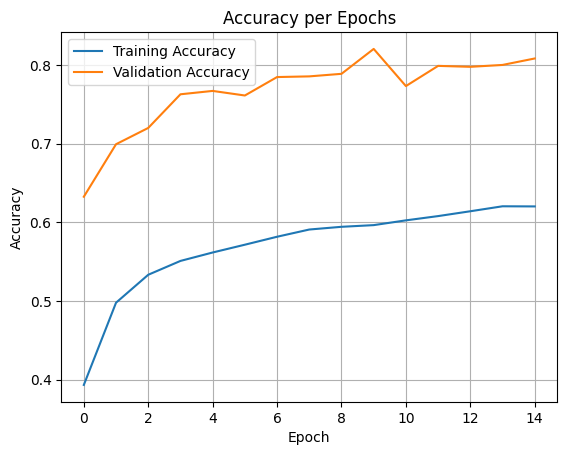

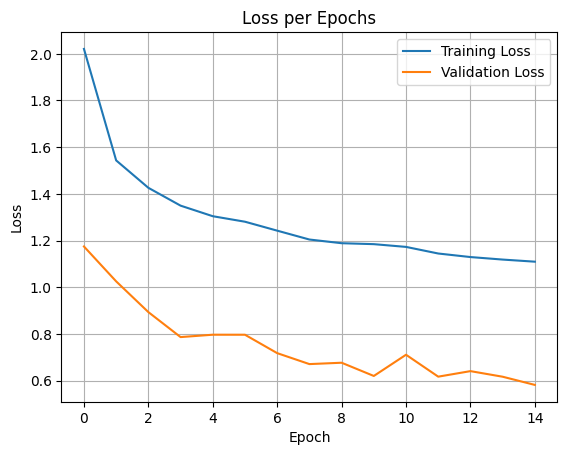

In [33]:

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
class_indices =  {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}

In [36]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array /= 255.0 # Rescale the image
    return img_array

# Predict the class of the image
def predict_image_class(model, img_path, class_indices):
    image_ = preprocess_image(img_path)
    predictions = model.predict(image_)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Get the class name from the index
    predicted_class_name = [key for key, value in class_indices.items() if value == predicted_class_index][0]
    return predicted_class_name

test_image = "/content/download (1).jpeg"

predicted_class= predict_image_class(model, test_image, class_indices)

print(f"The predicted class for the image is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The predicted class for the image is: Apple__Healthy


In [30]:
model.save("fresh_vs_rotten.h5")

In [32]:
from google.colab import files
files.download("fresh_vs_rotten.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>